In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [2]:
# Avoid OOM errors by limiting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# remove unqualified images from dataset
data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # if image is corrupted, remove it
            img = cv2.imread(image_path)
            if img is None:
                os.remove(image_path)
                continue
            tip = imghdr.what(image_path)
            # if image extension is not in image_exts, remove it
            if tip not in image_exts:
                os.remove(image_path)
        except Exception as e:
            print(e)
            os.remove(image_path)


In [4]:
# load data
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 299 files belonging to 2 classes.


In [5]:
# Preprocess data

# scale images to [0, 1], smaller is better for training
scaled_data = data.map(lambda x,y: (x/255 # x is the image
                             , y) # y is the label
                             ) # map is a lot faster than for loop
scaled_iterator = scaled_data.as_numpy_iterator()

In [6]:
batch = scaled_iterator.next()
print(batch[0].max(), batch[0].min())

1.0 0.0


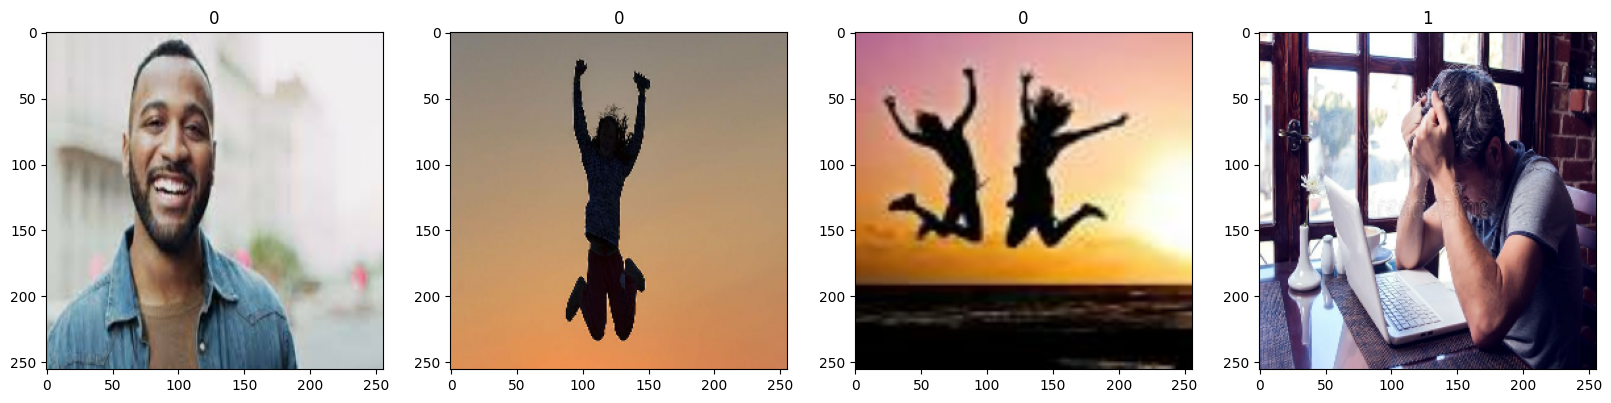

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image)
    ax[idx].set_title(batch[1][idx])

In [10]:
# Split Data
train_size = int(0.6 * len(scaled_data))
val_size = int(0.3 * len(scaled_data))
test_size = int(0.1 * len(scaled_data))
print(len(scaled_data), train_size, val_size, test_size, train_size + val_size + test_size)

train_data = scaled_data.take(train_size)
val_data = scaled_data.skip(train_size).take(val_size)
test_data = scaled_data.skip(train_size + val_size).take(test_size)

10 6 3 1 10


In [11]:
# Deep Learning Model

model = Sequential()
# adding a convolutional layer and max pooling layer
## Architectural decisions (influences what the model performs):
### 16 filters, 3x3 kernel size, 1 stride, relu activation, input shape
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D()) # default size 2x2, takes the max value after activation, condense the information

# adding another convolutional layer and max pooling layer
## 32 filters, ...
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# adding another convolutional layer and max pooling layer
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# flattening the output of the convolutional layers
model.add(Flatten()) # condense down to a single value

# adding another convolutional layer and max pooling layer
model.add(Dense(256, activation='relu')) # 256 neurons
model.add(Dense(1, activation='sigmoid')) # single output, sigmoid activation converts number to between 0 and 1
                                        # Essentially, 0 and 1 will decide the class of the image

In [12]:
# ADRs:
# I use adam optimizer, because it is the most popular: https://optimization.cbe.cornell.edu/index.php?title=Adam#:~:text=The%20name%20is%20derived%20from,weight%20of%20the%20neural%20network.
# I use binary crossentropy because I have two classes
# I use accuracy as a metric because I want to know how accurate the model is
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [13]:
# Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# fit is the training component, then predict is when we are going to make predictions
## train_data is the data we are going to train on
## epochs is the number of times we are going to train on the data
## validation_data is the data we are going to use to validate the model
## callbacks is a list of callbacks to use during training
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 5s 550ms/step - loss: 0.9786 - accuracy: 0.5312 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 2/20
6/6 [==============================] - 4s 529ms/step - loss: 0.6761 - accuracy: 0.6458 - val_loss: 0.6796 - val_accuracy: 0.6875
Epoch 3/20
6/6 [==============================] - 4s 530ms/step - loss: 0.6748 - accuracy: 0.7240 - val_loss: 0.6508 - val_accuracy: 0.6562
Epoch 4/20
6/6 [==============================] - 4s 522ms/step - loss: 0.6116 - accuracy: 0.7135 - val_loss: 0.5749 - val_accuracy: 0.7604
Epoch 5/20
6/6 [==============================] - 4s 522ms/step - loss: 0.5444 - accuracy: 0.7552 - val_loss: 0.4704 - val_accuracy: 0.8021
Epoch 6/20
6/6 [==============================] - 4s 525ms/step - loss: 0.4656 - accuracy: 0.8125 - val_loss: 0.4117 - val_accuracy: 0.8125
Epoch 7/20
6/6 [==============================] - 4s 527ms/step - loss: 0.4310 - accuracy: 0.8333 - val_loss: 0.4071 - val_accuracy: 0.8333
Epoch 8/20
6/6 [====

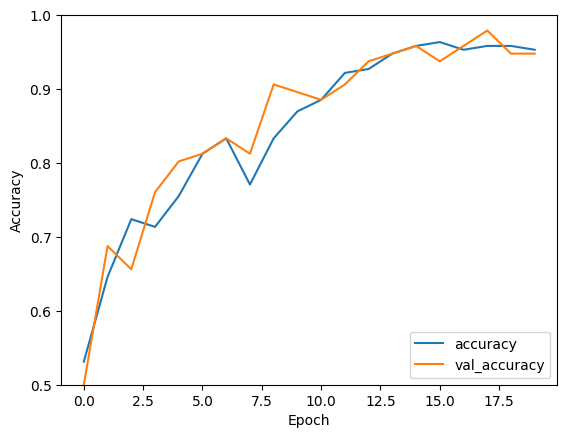

In [14]:
# Plot Performance
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [15]:
# Evaluate Performance
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred = np.round(y_pred)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)
print('Precision: ', precision.result().numpy())
print('Recall: ', recall.result().numpy())
print('Accuracy: ', accuracy.result().numpy())

1/1 [==============================] - 0s 86ms/step
Precision:  1.0
Recall:  1.0
Accuracy:  1.0


(256, 256, 3) (1, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
Happy


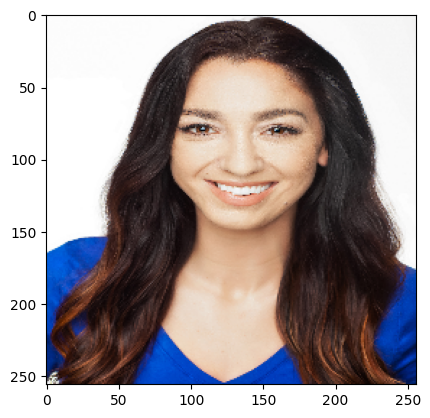

In [16]:
# Test on happy image
img = cv2.imread('happy_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
resize_img = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))

# predict
resize_img_array = np.expand_dims(resize_img/255, 0) #don't forget to scale the image
print(resize_img.shape, resize_img_array.shape)
predict_test_img = model.predict(resize_img_array)
if predict_test_img > 0.5:
    print('Sad')
else:
    print('Happy')

(256, 256, 3) (1, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step
Sad


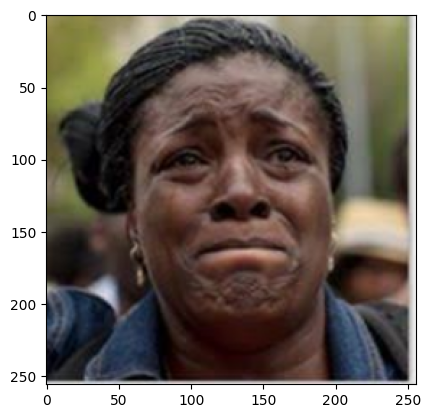

In [17]:
# Test on sad image
img = cv2.imread('sad_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
resize_img = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))

# predict
resize_img_array = np.expand_dims(resize_img/255, 0) #don't forget to scale the image
print(resize_img.shape, resize_img_array.shape)
predict_test_img = model.predict(resize_img_array)
if predict_test_img > 0.5:
    print('Sad')
else:
    print('Happy')

In [18]:
# Save Model
model.save('happy-sad-model.h5')